This notebook shows the use of Tab Transformer neural network architecture for a prediction probelm.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/model/tab_transformer.ipynb)


[![View Source on GitHub](https://img.shields.io/badge/github-view%20source-black.svg)](https://github.com/AtrCheema/ai4water_examples/blob/master/docs/source/_notebooks/model/tab_transformer.ipynb)

In [2]:
try:
    import ai4water
except (ImportError, ModuleNotFoundError):
    !pip install ai4water[tf2]

D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\C\Anaconda3\envs\tfcpu27_py39\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [3]:
import numpy as np

from ai4water import Model
from ai4water.utils.utils import TrainTestSplit
from ai4water.models.utils import gen_cat_vocab
from ai4water.models import TabTransformer
from ai4water.utils.utils import get_version_info
from ai4water.datasets import mg_photodegradation

from easy_mpl import bar_chart

In [4]:
for lib,ver in get_version_info().items():
    print(lib, ver)

python 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:16) [MSC v.1916 64 bit (AMD64)]
os nt
ai4water 1.06
lightgbm 3.3.1
tcn 3.4.0
catboost 0.26
xgboost 1.5.0
easy_mpl 0.21.3
SeqMetrics 1.3.3
tensorflow 2.7.0
keras.api._v2.keras 2.7.0
numpy 1.21.0
pandas 1.3.4
matplotlib 3.4.3
h5py 3.5.0
sklearn 1.0.1
shapefile 2.3.0
fiona 1.8.22
xarray 0.20.1
netCDF4 1.5.7
optuna 2.10.1
skopt 0.9.0
hyperopt 0.2.7
plotly 5.3.1
lime NotDefined
seaborn 0.11.2


In [5]:
data, *_ = mg_photodegradation()

In [6]:
data.shape

(1200, 12)

In [7]:
print(data.head())

   Surface area  Pore Volume  Catalyst_loading (g/L)  Light_intensity (W)  \
0           0.0          0.0                     0.0                  105   
1           0.0          0.0                     0.0                  105   
2           0.0          0.0                     0.0                  105   
3           0.0          0.0                     0.0                  105   
4           0.0          0.0                     0.0                  105   

   time (min)  solution_pH  HA (mg/L)  Ci (mg/L)  Cf (mg/L) Catalyst_type  \
0           0         5.45          0         10      10.00   no catalyst   
1          30         5.45          0         10       9.98   no catalyst   
2          60         5.45          0         10       9.96   no catalyst   
3          90         5.45          0         10       9.94   no catalyst   
4         120         5.45          0         10       9.87   no catalyst   

          Anions  Efficiency (%)  
0  without Anion             0.0  
1  w

In [8]:
NUMERIC_FEATURES = data.columns.to_list()[0:8]
CAT_FEATURES = ["Catalyst_type", "Anions"]
LABEL = "Efficiency (%)"


splitter = TrainTestSplit(seed=313)

data[NUMERIC_FEATURES] = data[NUMERIC_FEATURES].astype(float)
data[CAT_FEATURES] = data[CAT_FEATURES].astype(str)
data[LABEL] = data[LABEL].astype(float)

train_data, test_data, _, _ = splitter.split_by_random(data)
train_data.shape, test_data.shape


((840, 12), (360, 12))

In [9]:
# create vocabulary of unique values of categorical features
cat_vocabulary = gen_cat_vocab(data)

cat_vocabulary

{'Catalyst_type': ['0.25 wt% Pt-BFO',
  '0.5 wt% Pd-BFO',
  '0.5 wt% Pt-BFO',
  '1 wt% Ag-BFO',
  '1 wt% Pd-BFO',
  '1 wt% Pt-BFO',
  '2 wt% Ag-BFO',
  '2 wt% Pd-BFO',
  '2 wt% Pt-BFO',
  '3 wt% Ag-BFO',
  '3 wt% Pd-BFO',
  '4 wt% Ag-BFO',
  'commercial TiO2',
  'no catalyst',
  'pure BFO'],
 'Anions': ['Na2HPO4', 'Na2SO4', 'NaCO3', 'NaCl', 'NaHCO3', 'without Anion']}

In [10]:
train_x = [train_data[NUMERIC_FEATURES].values, train_data[CAT_FEATURES].values]
test_x = [test_data[NUMERIC_FEATURES].values, test_data[CAT_FEATURES].values]

In [11]:
depth = 3
num_heads = 4
hidden_units = 16
final_mpl_units = [84, 42]
num_numeric_features = len(NUMERIC_FEATURES)

In [18]:
model = Model(model=TabTransformer(
    cat_vocabulary=cat_vocabulary,
    num_numeric_features=num_numeric_features,
    hidden_units=hidden_units,
    final_mlp_units = final_mpl_units,
    depth=depth,
    num_heads=num_heads,
))


            building DL model for  
            regression problem using Model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_cat (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 cat_embeddings (CatEmbeddings)  (None, 2, 16)       336         ['Input_cat[0][0]']              
                                                                                                  
 layer_normalization_1 (LayerNo  (None, 2, 16)       32          ['cat_embeddings[0][0]']         
 rmalization)                                                                                     
                                                                                                  
 multi_head_at

assigning name Input_num to IteratorGetNext:0 with shape (None, 8)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 8)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
assigning name Input_num to IteratorGetNext:0 with shape (None, 8)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)


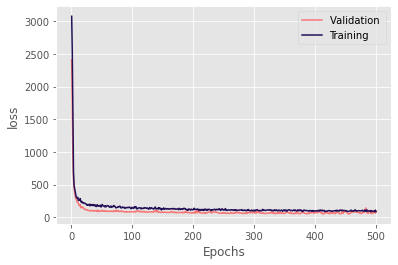

********** Successfully loaded weights from weights_456_49.76471.hdf5 file **********


In [13]:
_ = model.fit(x=train_x, y= train_data[LABEL].values,
              validation_data=(test_x, test_data[LABEL].values),
              epochs=500, verbose=0)

In [14]:
model.evaluate(x=train_x, y=train_data[LABEL].values, metrics=["r2", "r2_score", "rmse"])

assigning name Input_num to IteratorGetNext:0 with shape (None, 8)
assigning name Input_cat to IteratorGetNext:1 with shape (None, 2)
27/27 [==============================] - 0s 2ms/step


{'r2': 0.9548887536801427,
 'r2_score': 0.9534963094014572,
 'rmse': 6.893919813820322}

In [15]:
model.evaluate(x=test_x, y=test_data[LABEL].values, metrics=["r2", "r2_score", "rmse"])

12/12 [==============================] - 0s 2ms/step


{'r2': 0.952070663191044,
 'r2_score': 0.9510105449344268,
 'rmse': 7.054410196882702}

In [34]:

weights = model.get_intermediate_output('multi_head_attention', train_x)


print(f"found {len(weights)} layers with multi-head-attention weights named {weights.keys()}")

importances = []
for k, v in weights.items():
    out, importance = v
    importance = importance[:, :, 0, :]
    importances.append(np.sum(importance, axis=1))

atten_weights = np.sum(np.stack(importances), axis=0) / (depth * num_heads)
atten_weights.shape

found 3 layers with multi-head-attention weights named dict_keys(['multi_head_attention', 'multi_head_attention_1', 'multi_head_attention_2'])


(840, 2)

In [35]:

importance = np.sum(atten_weights, axis=0)
importance

array([423.76852, 416.23145], dtype=float32)

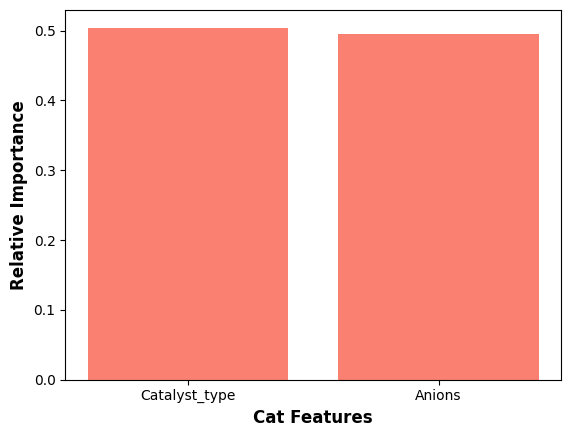

In [46]:
_ = bar_chart(importance/sum(importance),
              labels=CAT_FEATURES, 
              orient ="v",
              ax_kws=dict(ylabel="Relative Importance", ylabel_kws={"fontsize": 12, "weight": "bold"},
                         xlabel="Cat Features", xlabel_kws={"fontsize": 12, "weight": "bold"}),
              color="salmon"
             )